Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
%load_ext tensorboard

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno
import multiprocessing as mp

from pathlib import Path
import datetime

2023-03-07 00:02:20.529335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 00:02:20.647868: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 00:02:21.041900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/maxpow/miniconda3/envs/tf/lib/:/home/maxpow/miniconda3/envs/tf/lib/
2023-03-07 00:02:21.041963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_pl

In [3]:
DATA_ROOT = Path('data')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
class CFG:
    data_path = "data/"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [39]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])



In [40]:
features_filename = 'feature_data_keyframes_only_hands.npy'
labels_filename = 'label_data_keyframes_only_hands.npy'

In [ ]:
%%time
import multiprocessing as mp

def first_and_2_disparate_key_frame(data):
    # Initialize variables to store the maximum distance and the corresponding points
    max_distance = 0
    frame0 = 0
    frame1 = 0
    frame2 = 0
    point1 = None
    point2 = None

    where_are_NaNs = np.isnan(data)
    data[where_are_NaNs] = 0

    # Loop over all pairs of points in the array
    # and Compute the Euclidean distance between the current pair of points
    for i in range(1,data.shape[0]):
        for j in range(i+1, data.shape[0]):
            # Check if both points have all zeros for their coordinates
            if np.all(data[i] == 0) or np.all(data[j] == 0):
                print("Skipping zero-frame")
                continue

            distance = np.linalg.norm(data[j,:,:2] - data[i,:,:2])
            # If the distance is larger than the current maximum, update the maximum and the corresponding points
            if distance > max_distance:
                max_distance = distance
                point1 = data[i]
                point2 = data[j]
                frame1 = i
                frame2 = j

    data_new = np.zeros((3,543,3))
    data_new[0] = data[frame0,:,:]
    data_new[1] = data[frame1,:,:]
    data_new[2] = data[frame2,:,:]
    return data_new

def convert_row(row):
    _, row = row
    x = load_relevant_data_subset(f"{CFG.data_path}{row.path}")
    x = first_and_2_disparate_key_frame(x)

    # Feature Converter code - START    
    FRAMES = 3
    # Drop Z coordinate so we multiply by 2
    # face_x = x[:,:468,:2].reshape(-1, FRAMES*468*2) # Flatten array 
    lefth_x = x[:,468:489,:2].reshape(-1, FRAMES*21*2)
    # pose_x = x[:,489:522,:2].reshape(-1, FRAMES*33*2)
    righth_x = x[:,522:,:2].reshape(-1, FRAMES*21*2)

    # Concatenate features
    xs = []
    # xs.append(face_x)
    xs.append(lefth_x)
    # xs.append(pose_x)
    xs.append(righth_x)
    
    xfeat = np.zeros(sum(x.shape[1] for x in xs))
    start_index = 0
    for x in xs:
        xfeat[start_index:start_index+x.shape[1]] = x
        start_index += x.shape[1]
    # Feature Converter code - END

    return xfeat, row.label

def convert_and_save_data():
    df = train
    df = pd.read_csv(f"{CFG.data_path}train.csv")
    
    label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
    index_label = {label_index[key]: key for key in label_index}
    df["label"] = df["sign"].map(lambda sign: label_index[sign])    
    
    # npdata = np.zeros((df.shape[0], 543 * 2 * 3))
    npdata = np.zeros((df.shape[0], 42 * 2 * 3))    
    nplabels = np.zeros(df.shape[0])

    # for row in tqdm(df.iterrows(), total = df.shape[0]):
    #     i = row[0]
    #     x, y = convert_row(row)
    #     npdata[i,:] = x
    #     nplabels[i] = y

    
    with mp.Pool(processes=4) as pool:
        results = pool.imap_unordered(convert_row, df.iterrows(), chunksize=250)
        for i, (x,y) in tqdm(enumerate(results), total=df.shape[0]):
            npdata[i,:] = x
            nplabels[i] = y
            
    np.save(features_filename, npdata)
    np.save(labels_filename, nplabels)
    
convert_and_save_data()

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 58251/94477 [20:22<14:15, 42.37it/s]

In [25]:
# X = np.load(features_filename)
# y = np.load(labels_filename)

# X = X[:5000]
# y = y[:5000]
# print(X.shape, y.shape)

In [67]:
X = np.load(features_filename)
y = np.load(labels_filename)

## Save number of frames of each training sample for data analysis
# train["num_frames"] = num_frames
# print(train["num_frames"].describe())
# train.to_csv("train.csv", index=False)

print(X.shape, y.shape)

(94477, 252) (94477,)


In [ ]:
from keras.utils import plot_model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512,input_shape=X[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("gelu"),
    tf.keras.layers.Dropout(0.6),
    
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("gelu"),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("gelu"),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Dense(250, activation="softmax"),
])


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer='adam',
    metrics=[
        "accuracy",
        # tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        # tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

# plot_model(model)
model.summary()

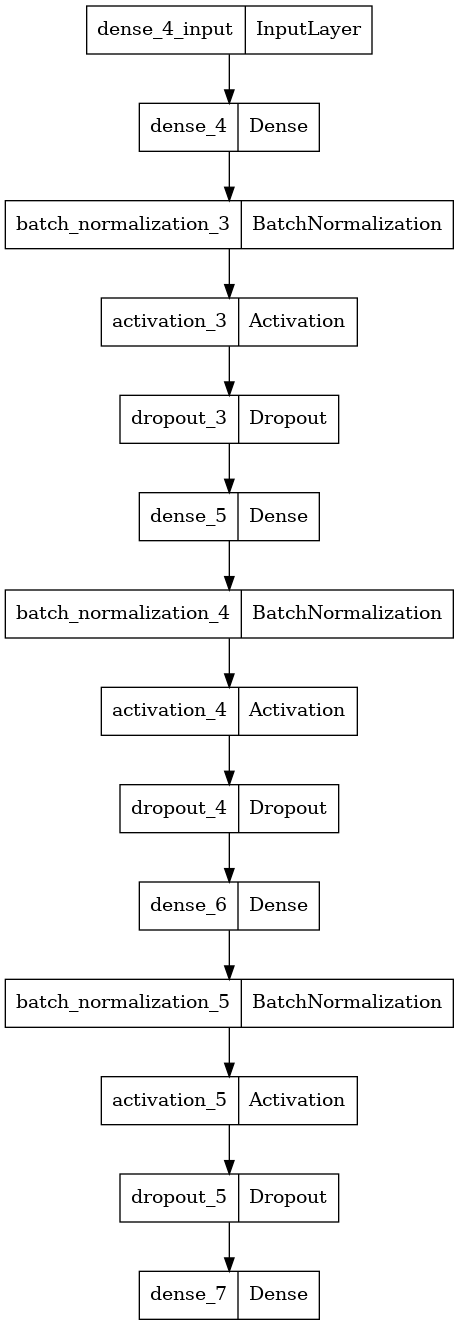

In [68]:
plot_model(model)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Double the training data by mirroring the coordinates over the x-axis

# X_train_mirrored = X_train.copy()
# X_train_mirrored[:,:,0] *= -1 # flip over x-axis to mirror the data
# y_train = np.concatenate((y_train, y_train))
# X_train = np.concatenate((X_train, X_train_mirrored))

## Keyset mirror by flipping [x1, y1, x2, y2, ..., x3528, y3528]
# X_train_mirrored = X_train.copy()
# X_train_mirrored[:,::2] *= -1
# X_train = np.concatenate((X_train, X_train_mirrored))
# y_train = np.repeat(y_train, 2, axis=0)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.h5", restore_best_weights=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y$Ym%d-%H%M%S-keyframes"), histogram_freq=1),
]
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), batch_size=64, callbacks=callbacks)    


In [54]:
# model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, callbacks=callbacks)
loaded_model = tf.keras.models.load_model('model.h5')
new_history = loaded_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, callbacks=callbacks)

Epoch 1/100
1181/1181 [==============================] - 13s 11ms/step - loss: 3.0696 - accuracy: 0.3125 - val_loss: 2.8182 - val_accuracy: 0.3795
Epoch 2/100
1181/1181 [==============================] - 12s 10ms/step - loss: 3.0698 - accuracy: 0.3113 - val_loss: 2.8097 - val_accuracy: 0.3816
Epoch 3/100
1181/1181 [==============================] - 10s 8ms/step - loss: 3.0702 - accuracy: 0.3131 - val_loss: 2.8141 - val_accuracy: 0.3810
Epoch 4/100
1181/1181 [==============================] - 14s 12ms/step - loss: 3.0649 - accuracy: 0.3142 - val_loss: 2.8059 - val_accuracy: 0.3823
Epoch 5/100
1181/1181 [==============================] - 13s 11ms/step - loss: 3.0639 - accuracy: 0.3105 - val_loss: 2.8113 - val_accuracy: 0.3807
Epoch 6/100
1181/1181 [==============================] - 13s 11ms/step - loss: 3.0628 - accuracy: 0.3143 - val_loss: 2.8070 - val_accuracy: 0.3806
Epoch 7/100
1181/1181 [==============================] - 11s 10ms/step - loss: 3.0644 - accuracy: 0.3147 - val_loss: 2.

In [55]:
import matplotlib.pyplot as plt
import numpy as np
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


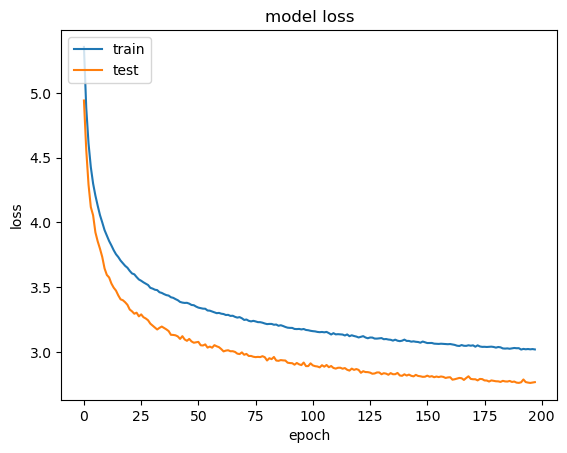

In [61]:
# summarize history for loss
plt.plot(history.history['loss'] + new_history.history['loss'])
plt.plot(history.history['val_loss'] + new_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

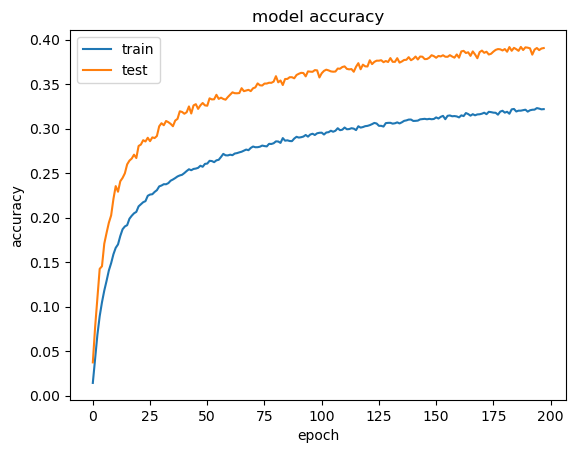

In [62]:
# summarize history for accuracy
plt.plot(history.history['accuracy'] + new_history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + new_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
def get_model():
    return model

In [64]:
get_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               129536    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [28]:
# inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
# x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
# x = tf.reduce_mean(x, axis=0, keepdims=True)

# # for i in range(1, len(model.layers)):
# x = model.layers[0](x)
# x = model.layers[1](x)
# x = model.layers[2](x)

In [65]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model


In [66]:
inference_model = get_inference_model(model)
inference_model.summary()

ValueError: Exception encountered when calling layer "dense_4" (type Dense).

Dimensions must be equal, but are 3 and 252 for '{{node dense_4/Tensordot/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](dense_4/Tensordot/Reshape, dense_4/Tensordot/ReadVariableOp)' with input shapes: [543,3], [252,512].

Call arguments received by layer "dense_4" (type Dense):
  • inputs=tf.Tensor(shape=(1, 543, 3), dtype=float32)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f"{CFG.data_path}{train.iloc[i].path}")
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))
    print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")
    total = i

In [ ]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)

In [ ]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')

In [ ]:
import zipfile
zipfile.ZipFile('submission.zip', mode='w').write('model.tflite')

In [ ]:
!ls -lh